In [306]:
# ============================================
# 1. IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import joblib

In [307]:
# ============================================
# 2. LOAD DATA
# ============================================
# Assume df is already loaded or do:
df = pd.read_csv("data/jobs_salaries_2023.csv")

# Load countries with region
countries = pd.read_csv("data/countries.csv")  # code,name,region

# Create feature: same_country (1 if employee and company locations match)
df["same_country"] = (
    df["employee_residence"] == df["company_location"]
).astype(int)

df = (
    df.merge(
        countries[["code", "region"]],
        left_on="company_location",
        right_on="code",
        how="left",
    )
    .rename(columns={"region": "company_region"})
    .drop(columns=["code"])

)

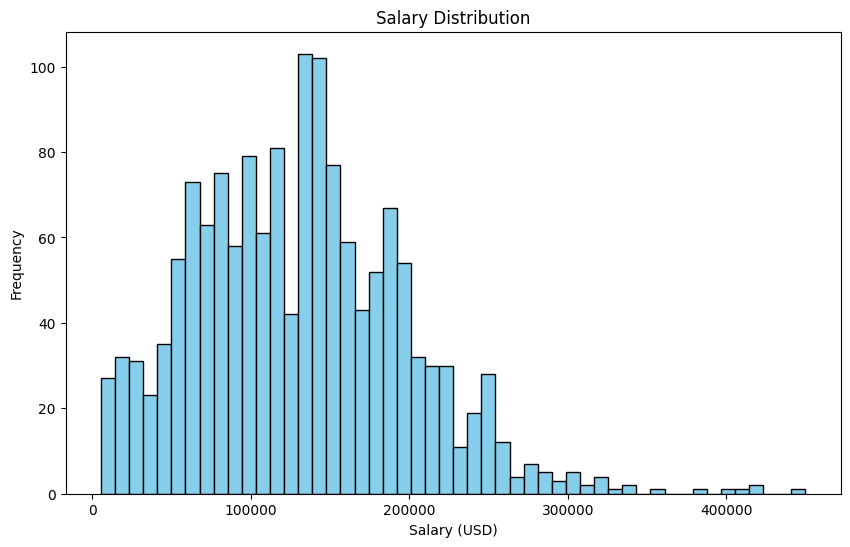

In [308]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df["salary_in_usd"], bins=50, color="skyblue", edgecolor="black")
plt.title("Salary Distribution")
plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")
plt.show()

In [309]:
categorical_cols = [
    "experience_level",
    "job_title",
    "company_location",
    "company_size",
]

numeric_cols = ["remote_ratio", "same_country"]

# Q1 = df["salary_in_usd"].quantile(0.25)
# Q3 = df["salary_in_usd"].quantile(0.75)
# IQR = Q3 - Q1

# # Define bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter data
# df_filtered = df[
#     (df["salary_in_usd"] >= lower_bound) & (df["salary_in_usd"] <= upper_bound)
# ]

df = df[df["salary_in_usd"] <= 300000]
print("Rows after removing salary > 300,000:", len(df))

# Keep relevant columns
df_model = df[
    [
        *categorical_cols,
        *numeric_cols,
        "salary_in_usd",
    ]
].dropna()

print(df_model.shape)
df_model.head

Rows after removing salary > 300,000: 1477
(1477, 7)


<bound method NDFrame.head of      experience_level                 job_title company_location company_size  \
0                  SE  Principal Data Scientist               ES            L   
1                  MI               ML Engineer               US            S   
2                  MI               ML Engineer               US            S   
3                  SE            Data Scientist               CA            M   
4                  SE            Data Scientist               CA            M   
...               ...                       ...              ...          ...   
1494               SE           Data Specialist               US            L   
1496               MI  Principal Data Scientist               US            L   
1497               EN            Data Scientist               US            S   
1498               EN     Business Data Analyst               US            L   
1499               SE      Data Science Manager               IN            L  

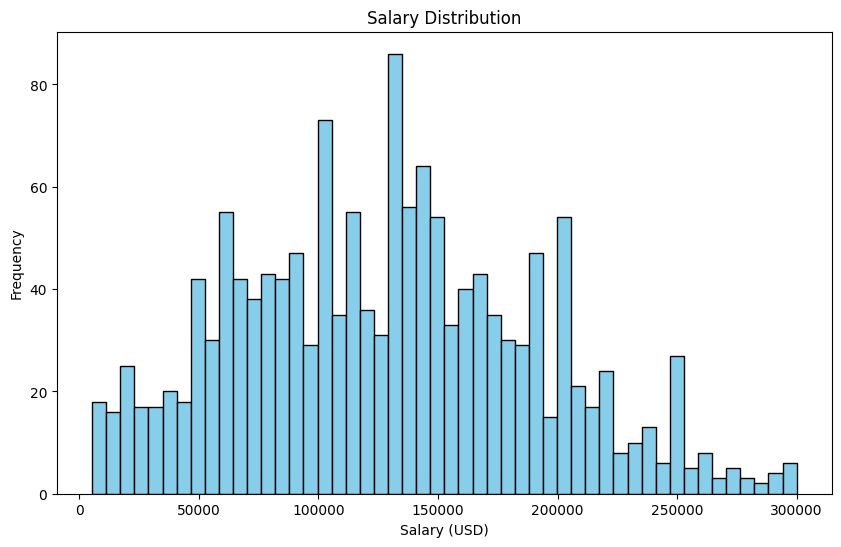

In [310]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df["salary_in_usd"], bins=50, color="skyblue", edgecolor="black")
plt.title("Salary Distribution")
plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")
plt.show()

In [311]:
# ============================================
# 3. FEATURES AND TARGET
# ============================================
X = df_model.drop(columns=["salary_in_usd"])
y = df_model["salary_in_usd"]

In [312]:
# ============================================
# 4. TRAIN/TEST SPLIT
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [313]:
# ============================================
# 5. PREPROCESSING (ONE-HOT ENCODE CATEGORICAL)
# ============================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

In [314]:
# ============================================
# 6. LINEAR REGRESSION PIPELINE
# ============================================
lr_model_combo = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

# Train model
lr_model_combo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['experience_level',
                                                   'job_title',
                                                   'company_location',
                                                   'company_size']),
                                                 ('num', 'passthrough',
                                                  ['remote_ratio',
                                                   'same_country'])])),
                ('regressor', LinearRegression())])

In [315]:
# ============================================
# 7. EVALUATE MODEL
# ============================================
y_pred_combo = lr_model_combo.predict(X_test)

print("Combined Feature Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_combo))
print("RMSE:", root_mean_squared_error(y_test, y_pred_combo))
print("R²:", r2_score(y_test, y_pred_combo))

# ============================================
# 8. SAVE MODEL
# ============================================
joblib.dump(
    lr_model_combo, "models/linear_regression_experience_employment_location_size.pkl"
)
print("Model saved to models/linear_regression_experience_employment_location_size.pkl")

Combined Feature Linear Regression Performance:
MAE: 33410.19698646341
RMSE: 42516.34457261039
R²: 0.5083592371561743
Model saved to models/linear_regression_experience_employment_location_size.pkl


In [316]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_estimators=200, random_state=42)),
    ]
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

joblib.dump(
    lr_model_combo, "models/random_forest_regression_experience_employment_location_size.pkl"
)
print(
    "Model saved to models/random_forest_regression_experience_employment_location_size.pkl"
)


Random Forest Performance:
MAE: 32984.38929946121
RMSE: 43156.83866000702
R²: 0.4934348647896758
Model saved to models/random_forest_regression_experience_employment_location_size.pkl


In [317]:
from sklearn.ensemble import GradientBoostingRegressor

rg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", GradientBoostingRegressor(n_estimators=200, random_state=42)),
    ]
)

rg_model.fit(X_train, y_train)
y_pred_rf = rg_model.predict(X_test)

print("\Gradient Boosting Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

joblib.dump(
    lr_model_combo,
    "models/gradient_boosting_regression_experience_employment_location_size.pkl",
)
print(
    "Model saved to models/gradient_boosting_regression_experience_employment_location_size.pkl"
)

\Gradient Boosting Performance:
MAE: 31986.492724072767
RMSE: 41134.00525099193
R²: 0.5398090793872841
Model saved to models/gradient_boosting_regression_experience_employment_location_size.pkl


<>:13: SyntaxWarning: invalid escape sequence '\G'
<>:13: SyntaxWarning: invalid escape sequence '\G'
/var/folders/jh/z981c7zj0vz0gmyfc8mhdxdr0000gn/T/ipykernel_37821/2305514778.py:13: SyntaxWarning: invalid escape sequence '\G'
  print("\Gradient Boosting Performance:")


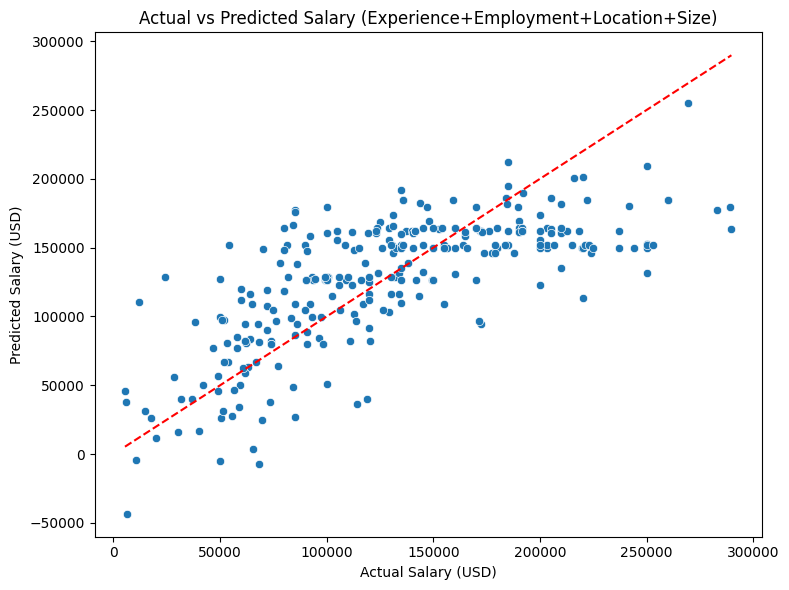

In [318]:
# ============================================
# 9. VISUALIZE: ACTUAL vs PREDICTED
# ============================================
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_combo)
plt.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--"
)  # Perfect prediction line
plt.title("Actual vs Predicted Salary (Experience+Employment+Location+Size)")
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.tight_layout()
plt.show()